# simsiam_VICReg

https://github.com/vturrisi/solo-learn/blob/da26b4dcbd69dab45593ceb031f04568f7659667/solo/losses/vicreg.py#L82

In [1]:
data_path = '../../dataset/bird_datasets/train'
classes_path = '../../dataset/bird_datasets/classes.txt'
training_labels_path = '../../dataset/bird_datasets/training_labels.txt'

batch_size = 16
# learning rate
learning_rate = 2e-4
weight_decay = 1e-4
WORKERS = 16
momentum = 0.9
output_foloder = 'model/model_bird_vic_simsiam_pretrain_500'
d = 1024
sim_weight=1.
var_weight=1.
cov_weight=1e-2

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/' + output_foloder, comment=f' batch_size={batch_size} lr={learning_rate}')
writer.add_text('Remark', 'batch_size = {}'.format(batch_size) , 0)
writer.add_text('Remark', 'learning_rate = {}'.format(learning_rate) , 0)
writer.add_text('Remark', output_foloder, 0)
writer.add_text('Remark', 'sim_weight = {}'.format(sim_weight), 0)
writer.add_text('Remark', 'var_weight = {}'.format(var_weight), 0)
writer.add_text('Remark', 'cov_weight = {}'.format(cov_weight), 0)
writer.add_text('Remark', 'momentum = {}'.format(momentum) , 0)
writer.add_text('Remark', 'weight_decay = {}'.format(weight_decay) , 0)
writer.add_text('Remark', 'layer d = {}'.format(d) , 0)

writer.flush()

In [3]:
import torch
import math

import os
import PIL.Image as Image
import numpy as np
from os import listdir
from os import walk
import glob
from torch.utils.data import Dataset
from torchvision import transforms

import numpy as np
from torchvision import transforms
from PIL import Image, ImageFilter
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

import torchvision.models as models
from torch import nn
from loss_functions.vicreg import simsiam_vicreg_loss_func
import torch.nn.functional as F
import torchvision.models as models
from swin_transformer_pytorch import SwinTransformer
from torch.optim.lr_scheduler import MultiStepLR, StepLR, ReduceLROnPlateau
from PIL import ImageFilter
import random
import timm

ModuleNotFoundError: No module named 'loss_functions'

## GPU Check

In [ ]:
print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

## read classes txt

In [5]:
class_to_idx = {}
with open(classes_path) as f:
    for line in f.readlines():
        label_num =  line.split(".")[0] 
        label_str =  line.split(".")[1][:-1]
        class_to_idx[int(label_num) - 1] = label_str

## read labels txt

In [6]:
data_list = []
with open(training_labels_path) as f:
    for line in f.readlines():
        file_name =  line.split(" ")[0]
        label_num =  int(line.split(" ")[1].split(".")[0]) -1
        label_str =  line.split(" ")[1].split(".")[1][:-1]
        data_list.append([file_name, label_num, label_str])

train_data_list = data_list[:int(len(data_list) * 0.8)]
val_data_list = data_list[int(len(data_list) * 0.8):int(len(data_list) * 0.9)]
test_data_list = data_list[int(len(data_list) * 0.9):]

print("all data : ", len(data_list))
print("train data : ", len(train_data_list))
print("val data : ", len(val_data_list))
print("test data : ", len(test_data_list))
print(train_data_list[:10])

all data :  3000
train data :  2400
val data :  300
test data :  300
[['4283.jpg', 114, 'Brewer_Sparrow'], ['3982.jpg', 161, 'Canada_Warbler'], ['5836.jpg', 143, 'Common_Tern'], ['5980.jpg', 7, 'Rhinoceros_Auklet'], ['4168.jpg', 160, 'Blue_winged_Warbler'], ['2352.jpg', 60, 'Heermann_Gull'], ['0511.jpg', 37, 'Great_Crested_Flycatcher'], ['4492.jpg', 146, 'Least_Tern'], ['1254.jpg', 131, 'White_crowned_Sparrow'], ['2792.jpg', 176, 'Prothonotary_Warbler']]


## define dataset

In [7]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir, data_list):
    images = []
    for img_name, idx, labels in data_list:
        item = (img_name, int(idx))
        images.append(item)
    return images

class BirdImageLoader(Dataset):
    def __init__(self, root, data_list, class_to_idx, transform=None, target_transform=None):
        imgs = make_dataset(root, data_list)

        self.root = root
        self.imgs = imgs
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img1 = self.transform(img)
            img2 = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img1, img2, target

    def __len__(self):
        return len(self.imgs)

## define data augmentation

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 
class GaussianBlur(object):
    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
def get_aug_trnsform():
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

def ge_eval_trnsform(s=1.0):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

aug_train = get_aug_trnsform()
aug_eval = ge_eval_trnsform()

In [9]:
dataset_train = BirdImageLoader(data_path, train_data_list, class_to_idx, transform=aug_train)
dataset_val = BirdImageLoader(data_path, val_data_list, class_to_idx, transform=aug_eval)
dataset_test = BirdImageLoader(data_path, test_data_list, class_to_idx, transform=aug_eval)

train_loader = DataLoader(
    dataset_train,
    num_workers=WORKERS,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    dataset_val,
    num_workers=WORKERS,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset_test,
    num_workers=WORKERS,
    batch_size=batch_size,
    shuffle=False
)

print('class_to_idx ', len(dataset_train.class_to_idx))
print('val_loader ', len(dataset_train.class_to_idx))
dataset_train.__len__()

class_to_idx  200
val_loader  200


2400

## define model

In [10]:
# make embedding to length=1
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

In [11]:
# encoder
encoder = timm.create_model('vit_base_patch16_224_miil_in21k', pretrained=True)

# projector
projector = nn.Sequential(
    nn.Linear(11221, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
    nn.Linear(2048, d), nn.BatchNorm1d(d), nn.ReLU(),
    nn.Linear(d, d), nn.BatchNorm1d(d)
) 

# predictor
predictor = nn.Sequential(
    nn.Linear(d, d), nn.BatchNorm1d(d), nn.ReLU(),
    nn.Linear(d, d)
)

encoder.to(device)
projector.to(device)
predictor.to(device)


Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=1024, bias=True)
)

In [12]:
# optimizer
from torch import optim

encoder_opt = optim.Adam(encoder.parameters(), lr=learning_rate)
projector_opt = optim.Adam(projector.parameters(), lr=learning_rate)
predictor_opt = optim.Adam(predictor.parameters(), lr=learning_rate)

encoder_opt = optim.SGD(encoder.parameters(), lr=learning_rate / 10.0, momentum = momentum, weight_decay=weight_decay)
projector_opt = optim.SGD(projector.parameters(), lr=learning_rate, momentum = momentum, weight_decay=weight_decay)
predictor_opt = optim.SGD(predictor.parameters(), lr=learning_rate, momentum = momentum, weight_decay=weight_decay)

encoder_scheduler = ReduceLROnPlateau(encoder_opt, 'min')
projector_scheduler = ReduceLROnPlateau(projector_opt, 'min')
predictor_scheduler = ReduceLROnPlateau(predictor_opt, 'min')

### save model

In [13]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

## Train

In [14]:
def pass_epoch(loader, mode = 'Train'):
    loss = 0
    loss_sim = 0
    loss_var = 0
    loss_cov = 0
    if (mode == 'Train'):
        encoder.train()
        projector.train()
    else:
        encoder.eval()
        projector.eval()
    for i_batch, image_batch in tqdm(enumerate(loader)):
        x1, x2 = image_batch[0].to(device), image_batch[1].to(device)
        # forward
        y1, y2 = encoder(x1), encoder(x2)
        z1, z2 = projector(y1), projector(y2)
        p1, p2 = predictor(z1), predictor(z2)

        # compute loos
        loss_batch, loss_batch_sim, loss_batch_var, loss_batch_cov = simsiam_vicreg_loss_func(z1, z2,p1, p2, sim_loss_weight=sim_weight, var_loss_weight=var_weight, cov_loss_weight=cov_weight) # loss
        loss += loss_batch
        loss_sim += loss_batch_sim
        loss_var += loss_batch_var
        loss_cov += loss_batch_cov

        if mode == 'Train':
            # update
            encoder_opt.zero_grad()
            projector_opt.zero_grad()
            predictor_opt.zero_grad()
            loss_batch.backward()
            encoder_opt.step()
            projector_opt.step()  
            predictor_opt.step()
    return loss / (i_batch + 1), loss_sim / (i_batch + 1), loss_var / (i_batch + 1), loss_cov / (i_batch + 1)

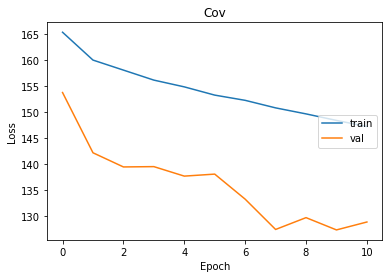

66it [00:29,  2.19it/s]

In [ ]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 

epochs = 100

loss_history_train = []
loss_history_train_sim = []
loss_history_train_var = []
loss_history_train_cov = []
loss_history_val = []
loss_history_val_sim = []
loss_history_val_var = []
loss_history_val_cov = []

def update_loss_hist(train_list, val_list, name='result', ylim = None):
    clear_output(wait=True)
    if (ylim != None):
        plt.ylim(0, ylim)
    plt.plot(train_list)
    plt.plot(val_list)
    plt.title(name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='center right')
    plt.savefig('./{}/{}.png'.format(output_foloder, name))
    plt.show()

# train loop
for epoch in range(epochs):
    train_loss, train_loss_sim, train_loss_var, train_loss_cov = pass_epoch(train_loader, 'Train')
    with torch.no_grad():
        val_loss, val_loss_sim, val_loss_var, val_loss_cov = pass_epoch(val_loader, 'Eval')

    
    writer.add_scalars('loss', {'train':train_loss, 'val':val_loss}, epoch)
    writer.add_scalars('sim', {'train':train_loss_sim, 'val':val_loss_sim}, epoch)
    writer.add_scalars('var', {'train':train_loss_var, 'val':val_loss_var}, epoch)
    writer.add_scalars('cov', {'train':train_loss_cov, 'val':val_loss_cov}, epoch)
    
    loss_history_train.append(train_loss)
    loss_history_train_sim.append(train_loss_sim)
    loss_history_train_var.append(train_loss_var)
    loss_history_train_cov.append(train_loss_cov)

    loss_history_val.append(val_loss)
    loss_history_val_sim.append(val_loss_sim)
    loss_history_val_var.append(val_loss_var)
    loss_history_val_cov.append(val_loss_cov)
    update_loss_hist(loss_history_train, loss_history_val, 'Loss')
    update_loss_hist(loss_history_train_sim, loss_history_val_sim, 'Sim')
    update_loss_hist(loss_history_train_var, loss_history_val_var, 'Var')
    update_loss_hist(loss_history_train_cov, loss_history_val_cov, 'Cov')
    encoder_scheduler.step(val_loss)
    projector_scheduler.step(val_loss)
    projector_scheduler.step(val_loss)
    
    save_checkpoint({
        'epoch': epoch + 1,
        'sim_weight': sim_weight,
        'var_weight': var_weight,
        'cov_weight': cov_weight,
        'state_dict': encoder.state_dict(),
        'optimizer' : encoder.state_dict(),
    }, is_best=False, filename='./{}/checkpoint_{:04d}.pth.tar'.format(output_foloder, epoch + 1))
torch.save(encoder, './{}/checkpoint.pth.tar'.format(output_foloder))
torch.cuda.empty_cache()